## Reading Tutorials
##### [Simple audio recognition: Recognizing keywords](https://www.tensorflow.org/tutorials/audio/simple_audio)

In [1]:
import os,pathlib,pylab as pl,seaborn as sb
import numpy as np,pandas as pd,tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing as tkp
import tensorflow.keras.layers as tkl,tensorflow.keras.models as tkm
from IPython import display
rs=42; tf.random.set_seed(rs); np.random.seed(rs)

In [2]:
datadir=pathlib.Path('data/mini_speech_commands')
if not datadir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin='http://storage.googleapis.com/download.tensorflow.org/'+\
               'data/mini_speech_commands.zip',
        extract=True,cache_dir='.',cache_subdir='data')

In [3]:
names=np.array(tf.io.gfile.listdir(str(datadir)))
names=names[names!='README.md']
print('command names: ',names)

command names:  ['yes' 'right' 'stop' 'go' 'no' 'up' 'left' 'down']


In [4]:
files=tf.io.gfile.glob(str(datadir)+'/*/*')
files=tf.random.shuffle(files)
num_samples=len(files)
print('number of total examples:',num_samples)
print('number of examples per label:',
      len(tf.io.gfile.listdir(str(datadir/names[0]))))
print('examples of the file tensor:',files[:10])

number of total examples: 8000
number of examples per label: 1000
examples of the file tensor: tf.Tensor(
[b'data/mini_speech_commands/up/76424fa5_nohash_0.wav'
 b'data/mini_speech_commands/right/21cbe292_nohash_1.wav'
 b'data/mini_speech_commands/up/ffd2ba2f_nohash_0.wav'
 b'data/mini_speech_commands/right/fce65496_nohash_1.wav'
 b'data/mini_speech_commands/yes/57376a4c_nohash_0.wav'
 b'data/mini_speech_commands/go/05d18852_nohash_0.wav'
 b'data/mini_speech_commands/up/48463cbc_nohash_2.wav'
 b'data/mini_speech_commands/go/e95c70e2_nohash_1.wav'
 b'data/mini_speech_commands/stop/ce7a8e92_nohash_2.wav'
 b'data/mini_speech_commands/down/529eda42_nohash_1.wav'], shape=(10,), dtype=string)


In [5]:
train_files=files[:int(.8*num_samples)]
valid_files=files[int(.8*num_samples):int(.9*num_samples)]
test_files=files[-int(.9*num_samples):]

In [6]:
def get_audio(file_path):
    audio,_=tf.audio.decode_wav(file_path)
    return tf.squeeze(audio,axis=-1)
def get_label(file_path):
    file_path=tf.strings.split(file_path,os.path.sep)
    return file_path[-2]
def get_audio_and_label(file_path):
    audio_binary=tf.io.read_file(file_path)
    audio=get_audio(audio_binary)
    label=get_label(file_path)
    return audio,label
get_label(files[0]).numpy()

b'up'

In [7]:
AUTOTUNE=tf.data.AUTOTUNE
train_files_ds=tf.data.Dataset.from_tensor_slices(train_files)
train_audio_ds=train_files_ds.map(
    get_audio_and_label,num_parallel_calls=AUTOTUNE)

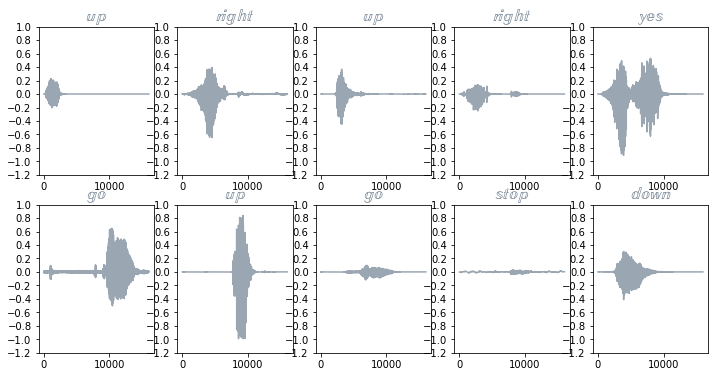

In [8]:
rows,cols=2,5
fig,axes=pl.subplots(rows,cols,figsize=(12,6))
for i,(audio,label) in enumerate(train_audio_ds.take(rows*cols)):
    ax=axes[i//cols][i%cols]
    ax.plot(audio.numpy(),color='slategray',alpha=.7)
    ax.set_yticks(np.arange(-1.2,1.2,.2))
    label=label.numpy().decode('utf-8')
    ax.set_title('$\mathbb{'+label+'}$',
                 color='slategray',fontsize='xx-large')
pl.show()

In [9]:
def get_spectrogram(audio,num=16000,frame_length=255,frame_step=128):
    zeros=tf.zeros([num]-tf.shape(audio),dtype=tf.float32)
    audio=tf.cast(audio,tf.float32)
    equal_length=tf.concat([audio,zeros],0)
    # a Fourier transform with time information
    spectrogram=tf.signal.stft(
        equal_length,frame_length=frame_length,frame_step=frame_step)
    # the magnitude
    spectrogram=tf.abs(spectrogram)
    return spectrogram

In [10]:
for audio,label in train_audio_ds.take(1):
    label=label.numpy().decode('utf-8')
    spectrogram=get_spectrogram(audio)
print('label: ',label)
print('shape of audio tensors: ',audio.shape)
print('spectrogram shape: ',spectrogram.shape)
print('audio playback: ')
display.display(display.Audio(audio,rate=16000))

label:  up
shape of audio tensors:  (16000,)
spectrogram shape:  (124, 129)
audio playback: 


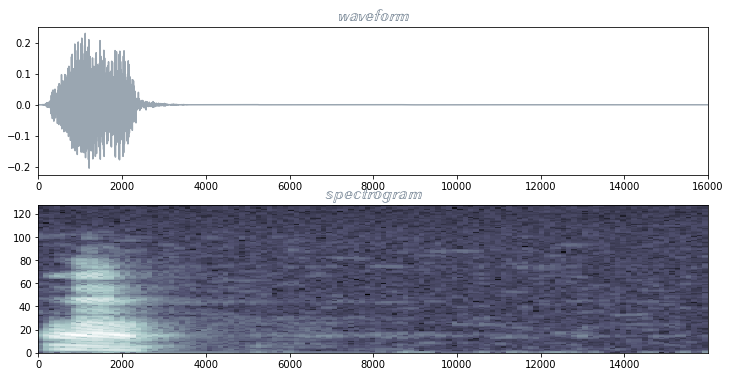

In [11]:
def plot_spectrogram(spectrogram,ax):
    log_spec=np.log(spectrogram.T)
    height=log_spec.shape[0]
    width=log_spec.shape[1]
    x=np.linspace(0,np.size(spectrogram),num=width,dtype=int)
    y=range(height)
    ax.pcolormesh(x,y,log_spec,cmap='bone')
fig,axes=pl.subplots(2,figsize=(12,6))
timescale=np.arange(audio.shape[0])
axes[0].plot(timescale,audio.numpy(),alpha=.7,color='slategray')
axes[0].set_title('$\mathbb{'+'waveform'+'}$',
                  color='slategray',fontsize='xx-large')
axes[0].set_xlim([0,16000])
plot_spectrogram(spectrogram.numpy(),axes[1])
axes[1].set_title('$\mathbb{'+'spectrogram'+'}$',
                  color='slategray',fontsize='xx-large')
pl.show()

In [12]:
def get_spectrogram_and_label_id(audio,label):
    spectrogram=get_spectrogram(audio)
    spectrogram=tf.expand_dims(spectrogram,-1)
    label_id=tf.argmax(label==names)
    return spectrogram,label_id

In [13]:
def preprocess_ds(files):
  files_ds=tf.data.Dataset.from_tensor_slices(files)
  output_ds=files_ds.map(
      get_audio_and_label,num_parallel_calls=AUTOTUNE)
  output_ds=output_ds.map(
      get_spectrogram_and_label_id,num_parallel_calls=AUTOTUNE)
  return output_ds

In [14]:
train_ds=preprocess_ds(train_files)
valid_ds=preprocess_ds(valid_files)
test_ds=preprocess_ds(test_files)

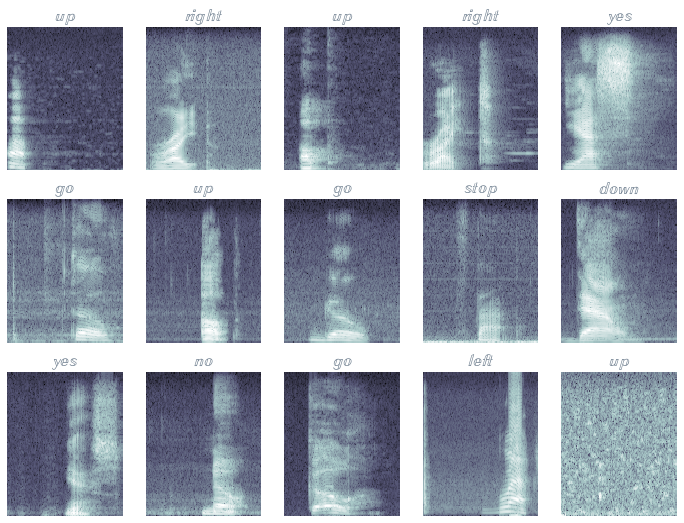

In [15]:
rows,cols=3,5
fig,axes=pl.subplots(rows,cols,figsize=(12,9))
for i,(spectrogram,label_id) in enumerate(train_ds.take(rows*cols)):
    ax=axes[i//cols][i%cols]
    plot_spectrogram(np.squeeze(spectrogram.numpy()+.1**10),ax)
    ax.set_title('$\mathbb{'+names[label_id.numpy()]+'}$',
                 color='slategray',fontsize='xx-large')
    ax.axis('off')
pl.show()

In [17]:
for spectrogram,_ in train_ds.take(1):
  input_shape=spectrogram.shape
num_labels=len(names)
norm_layer=tkp.Normalization()
norm_layer.adapt(train_ds.map(lambda x,_:x))
model=tkm.Sequential([
    tkl.InputLayer(input_shape=input_shape),
    tkp.Resizing(32,32), 
    norm_layer,
    tkl.Conv2D(32,3,activation='relu'),
    tkl.Conv2D(96,3,activation='relu'),
    tkl.MaxPooling2D(),
    tkl.Dropout(.25),
    tkl.Flatten(),
    tkl.Dense(256,activation='relu'),
    tkl.Dropout(.5),
    tkl.Dense(num_labels),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_1 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 96)        27744     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 96)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 96)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18816)             0

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [18]:
batch_size=64
train_ds=train_ds.batch(batch_size)
valid_ds=valid_ds.batch(batch_size)

In [19]:
train_ds=train_ds.cache().prefetch(AUTOTUNE)
valid_ds=valid_ds.cache().prefetch(AUTOTUNE)

In [21]:
epochs=10
history=model.fit(
    train_ds,validation_data=valid_ds,epochs=epochs,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1,patience=3))

Epoch 1/10
100/100 [==============================] - 54s 533ms/step - loss: 1.6534 - accuracy: 0.4191 - val_loss: 1.2190 - val_accuracy: 0.6187
Epoch 2/10
100/100 [==============================] - 34s 342ms/step - loss: 1.0456 - accuracy: 0.6355 - val_loss: 0.8681 - val_accuracy: 0.7387
Epoch 3/10
100/100 [==============================] - 34s 344ms/step - loss: 0.7557 - accuracy: 0.7373 - val_loss: 0.7159 - val_accuracy: 0.7725
Epoch 4/10
100/100 [==============================] - 35s 345ms/step - loss: 0.6027 - accuracy: 0.7969 - val_loss: 0.6967 - val_accuracy: 0.7812
Epoch 5/10
100/100 [==============================] - 35s 349ms/step - loss: 0.5114 - accuracy: 0.8230 - val_loss: 0.5884 - val_accuracy: 0.8225
Epoch 6/10
100/100 [==============================] - 34s 335ms/step - loss: 0.4382 - accuracy: 0.8442 - val_loss: 0.5526 - val_accuracy: 0.8263
Epoch 7/10
100/100 [==============================] - 33s 334ms/step - loss: 0.3748 - accuracy: 0.8691 - val_loss: 0.5626 - val_ac

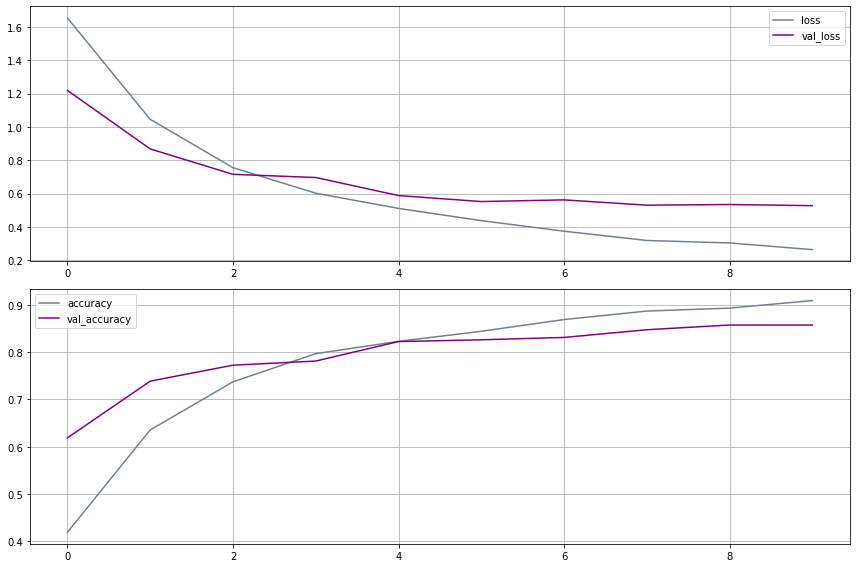

In [31]:
def keras_history_plot(fit_history,fig_size,color):
    keys=list(fit_history.history.keys())
    list_history=[fit_history.history[keys[i]] for i in range(len(keys))]
    dfkeys=pd.DataFrame(list_history).T
    dfkeys.columns=keys
    fig=pl.figure(figsize=(fig_size,fig_size/1.5))
    ax1=fig.add_subplot(2,1,1)
    dfkeys.iloc[:,[int(0),int(2)]].plot(
        ax=ax1,color=['slategray',color],grid=True)
    ax2=fig.add_subplot(2,1,2)
    dfkeys.iloc[:,[int(1),int(3)]].plot(
        ax=ax2,color=['slategray',color],grid=True)
    pl.tight_layout(); pl.show()
keras_history_plot(history,12,'purple')

In [30]:
test_audio,test_labels=[],[]
for audio,label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())
test_audio=np.array(test_audio)
test_labels=np.array(test_labels)

In [32]:
test_preds=np.argmax(model.predict(test_audio),axis=1)
test_acc=sum(test_preds==test_labels)/len(test_labels)
print(f'test accuracy:{test_acc:.0%}')

test accuracy:94%


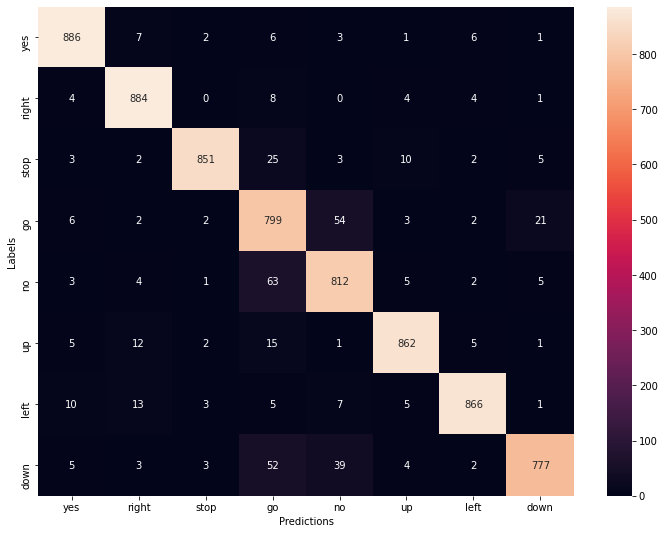

In [33]:
confusion_mtx=tf.math.confusion_matrix(test_labels,test_preds) 
pl.figure(figsize=(12,9))
sb.heatmap(confusion_mtx,xticklabels=names,yticklabels=names, 
            annot=True,fmt='g')
pl.xlabel('Predictions'); pl.ylabel('Labels')
pl.show()